In [5]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

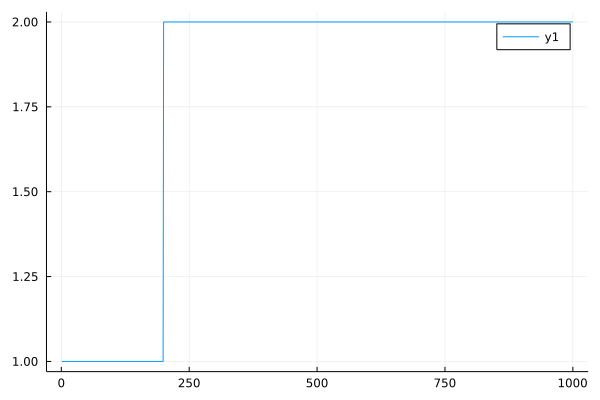

In [6]:
include("../src/swar_model.jl")
include("../src/swar_utils.jl")

## Switching AR

In [36]:
# cherry picking
# seed 22
γs = [1.0, 0.1]
θs = [[0.3, 0.1], [0.1, -0.2]]

γs = [1.0, 1.0]
θs = [[-0.3, 0.5, 0.2], [0.1, -0.2, 0.05]]

2-element Vector{Vector{Float64}}:
 [-0.3, 0.5, 0.2]
 [0.1, -0.2, 0.05]

## Generate AR

In [108]:
using Random
Random.seed!(22)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

γs = [1, 30]
# γs = [1.0, 0.1]
θs = [[1.25166, -0.423974], [1.04586, -0.198375]]
# θs = [randn(2), randn(2)]
# γs = [1.0, 0.1]
# θs = [[0.3, 0.1], [0.1, -0.2]]
# θs = [[0.3, 0.1, -0.2], [0.1, -0.2, -0.5]]
# ARorder = length(first(θs))

# @assert length(γs) == length(θs)

# nmixtures = length(γs)
# n_samples = 5000
# x = 0.1*ones(ARorder)
# # x = [1.0, 2.0]

# n_slice_n = 500

# for i in 1:n_samples
#     i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
#     dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
#     push!(x, rand(dist))
# end
# inputs = x[1:n_samples+1]
# outputs = circshift(x, -1)

# inputs = inputs[1:end-1]
# outputs = outputs[2:end-1]
A, states, obs = generateSwAR(1000, 100, 2, 0.5ones(2), θs, γs)

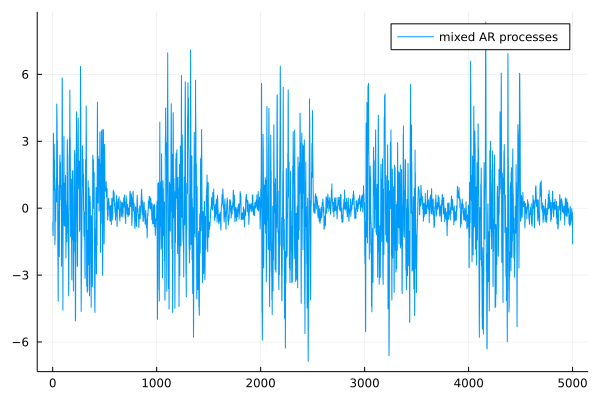

In [109]:
plot(outputs, label="mixed AR processes")

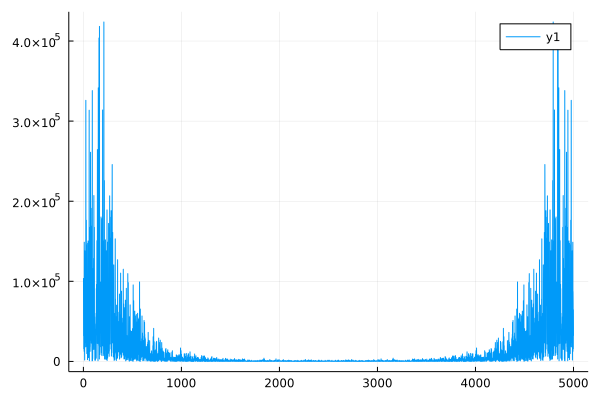

In [110]:
using FFTW
plot(abs.(fft(outputs)).^2)

In [111]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:size(inputs_, 1)]

4998-element Vector{Float64}:
 -0.6119559641162322
 -0.9990558130157109
 -0.9253740479357124
 -1.2341692132255524
 -0.2887123366421197
  1.4503196218531538
  3.3642597200718862
  3.045095776665351
  2.080569571466989
  1.2527254294307888
  2.5313690014614005
  1.4301995044395428
  1.968283585590349
  ⋮
 -0.48658186907410295
 -0.5550724326958343
 -0.4388595461191563
 -0.434767591518664
 -0.08158786671909574
 -0.019197267983323774
 -0.12558891799294947
 -0.26673067225915414
 -0.34948780914202415
 -0.22836823804467724
 -0.25662509330639455
 -0.1866609365711044

In [112]:
# csep = 1000.0

priors_as = map(γ -> infgamma(Float64, γ), γs)
priors_bs = map(_ -> infgamma(Float64, 1.0), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ[1], θ[2]), zip(θs, [diageye(ARorder), diageye(ARorder)]))
priors_ws = map(_ -> (ARorder, diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))
n_mixtures = 2
prior_s = fill(1.0 / n_mixtures, n_mixtures)
prior_A = ones(n_mixtures, n_mixtures)
parameters = SWARParameters(n_mixtures, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SWARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=900000.0, b=30000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [1.25166, -0.423974]
Λ: [1.0 0.0; 0.0 1.0]
)
, MvNormalMeanPrecision(
μ: [1.04586, -0.198375]
Λ: [1.0 0.0; 0.0 1.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

In [113]:
mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_swar(inputs_, outputs_, 100, 10, parameters);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [114]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.886593  0.0996837
 0.113407  0.900316

In [115]:
minimum(mean.(mγs[end]))

0.6523633303049969

In [116]:
mean.(mθs[end])

100-element Vector{Vector{Float64}}:
 [1.1654633803750702, -0.3160562200396746]
 [1.2764546428059895, -0.5299717554849818]
 [1.0844489474386794, -0.36072366816636353]
 [1.2720158482553017, -0.46460352323387977]
 [1.3746564205663363, -0.5311143361840397]
 [1.327730405042101, -0.4782038988117618]
 [1.2308743684650894, -0.4508304016729746]
 [1.1793348665997536, -0.3339501301956084]
 [1.2843004232349329, -0.4295921793909556]
 [1.2447976608482814, -0.5230149576785805]
 [1.088249539748199, -0.24268860760192176]
 [1.0738856757935358, -0.27947593405986787]
 [1.137908037520234, -0.3687536431896072]
 ⋮
 [1.1079929050094144, -0.3716229879475061]
 [1.4252651801885576, -0.5534677385449978]
 [1.1755126803873845, -0.40516923116206566]
 [0.8948420732059743, -0.05066329966804674]
 [1.0246303937740733, -0.15139637824141022]
 [1.2015159508060675, -0.28825863838078364]
 [0.8493257765427512, -0.11850942682057115]
 [0.9304389769337068, -0.2057690542798313]
 [0.9882852765279244, -0.22015549411949512]
 [1.063

In [117]:
using Plots

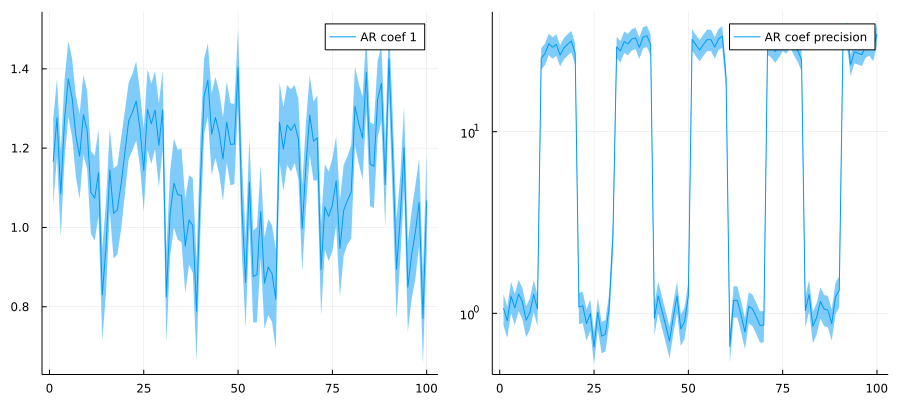

In [120]:
dim(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index), label="AR coef $(index)")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")

plot(p1, p2, size = (900, 400))

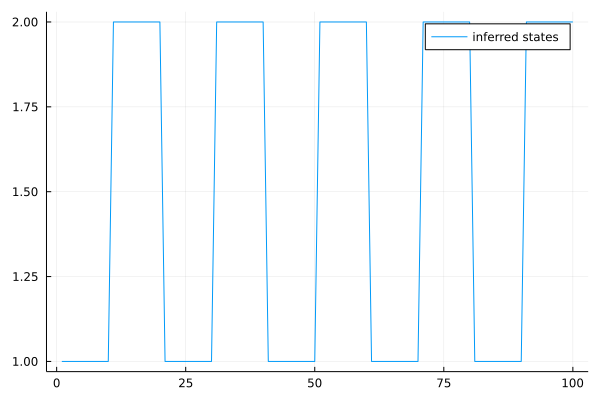

In [119]:
plot(mean.(mzs[end][1:end]), label="inferred states")

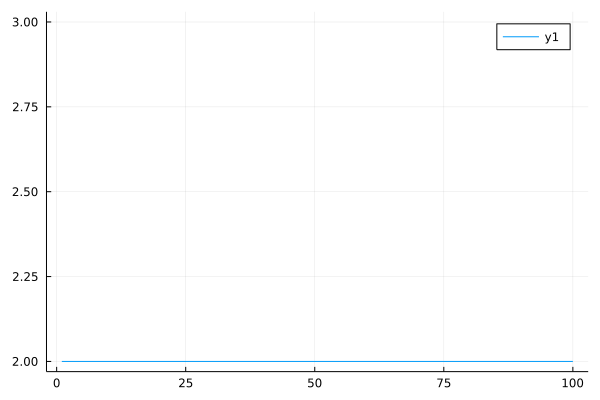

In [107]:
plot(round.(mean.(mzs[end])))

In [93]:
mean.(mzs[end])

100-element Vector{Float64}:
 1.960402464489998
 1.995334462246119
 1.9939556513613892
 1.9982729248978026
 1.9992077768066399
 1.9988995486088184
 1.9977380219832617
 1.9946653221269623
 1.9951057820988436
 1.9747716719490114
 1.6915598909686216
 1.0282658239731222
 1.000312653949819
 ⋮
 1.9822417590515342
 1.9423307101559688
 1.0033594825606922
 1.0000005670226393
 1.0010435957557329
 1.000513461102556
 1.0000537887800764
 1.000171910655782
 1.0000445274960685
 1.0000363211751782
 1.0000143838506645
 1.000026324587887

mfe[end - 4:end] = [-4525.775968545867, -4681.695287754803, -4774.295878515206, -4830.400224049228, -4864.931474016021]


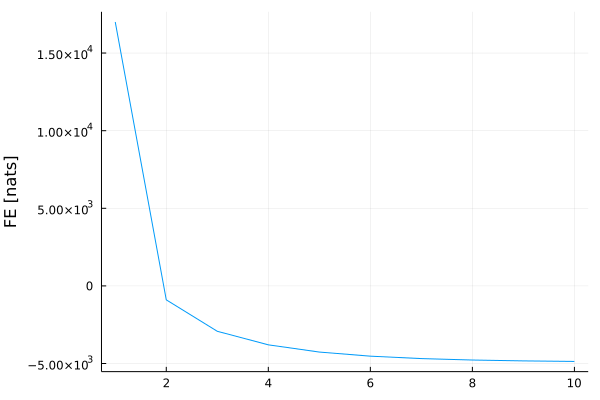

In [94]:
@show mfe[end-4:end]
plot(mfe[1:end], label=:none, ylabel="FE [nats]")